In [1]:
import sys,os,pickle,copy
sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
import numpy as np
import numpy
import pandas as pd
import scipy
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
from importlib import reload
import seaborn as sns

import preprocess as prep

from sklearn.decomposition import NMF

import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
import matplotlib.pyplot as plt

import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

<module 'nmf_analysis' from '/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py'>

In [2]:
sess_name="e15_13f1_220117"
py_data_dir = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data"
fr_ = pickle.load(open(os.path.join(py_data_dir,'fr.p'),'rb'))
pos_bins = fr_['pos_bins']['lin']
bin_to_lin=numpy.concatenate([pos_bins[:-1,None],pos_bins[1:,None]],axis=1).mean(axis=1)

fr = fr_['df']['pyr']
fr_map_trial = pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map_trial']
fr_map_avg=pickle.load(open(os.path.join(py_data_dir,'fr_map.p'),'rb'))['fr_map']
cell_cols = fr_['cell_cols']
cell_cols_pyr=np.array(cell_cols['pyr'],dtype=object)

In [3]:
data_dir_full = "/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117"
to_return=prep.load_stuff(data_dir_full)

cell_metrics=to_return['cell_metrics']
behavior=to_return['behavior']
ripple_events=to_return['ripple_events']
mergepoints=to_return['mergepoints']
cell_type_mask=to_return['cell_type_mask']
pyr_uid=to_return['pyr_uid']

trial_ind_d = {ch:np.nonzero(behavior.trials.visitedArm==ch)[0] for ch in [0,1]}
dt = np.diff(behavior.timestamps).mean()

In [4]:
speed_thresh = 2.5
speed_mask = fr['speed'] > speed_thresh
speed_mask_slow = np.logical_not(speed_mask)
fr_d_fast = na.get_mean_fr_by_trial_types(fr,cell_cols_pyr,speed_mask)
fr_d_slow = na.get_mean_fr_by_trial_types(fr,cell_cols_pyr,speed_mask_slow)

In [6]:
fr_filtered = copy.copy(fr.query("(speed>=1.)"))
# fr_filtered[cell_cols_pyr] = fr_filtered[cell_cols_pyr] / dt
fr_mean_trial_type = fr_filtered.groupby(['visitedArm','trial']).mean()[cell_cols_pyr]
fr_mean_all = fr_filtered.groupby('trial').mean()[cell_cols_pyr]

fr_to_be_nmfed = {'0':fr_mean_trial_type.loc[0],'1':fr_mean_trial_type.loc[1],'both':fr_mean_all}



In [16]:
reload(na)
n_compo = 4
model_d, W_sorted_d,W_inds_d, factor_assignment_d, H_sorted_d, X_sorted_d, X_recon_sorted_d,pyr_mask_joint,non_na_original_ind_joint=na.nmf_multiple_fr_df_once(fr_to_be_nmfed,n_compo)




/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:51: RuntimeWarning: invalid value encountered in true_divide
  X_normed = X / row_norm_constant


(<Figure size 666x476.64 with 4 Axes>,
 {'W': <AxesSubplot:label='W', xlabel='component', ylabel='neuron'>,
  'H': <AxesSubplot:label='H', ylabel='component'>})

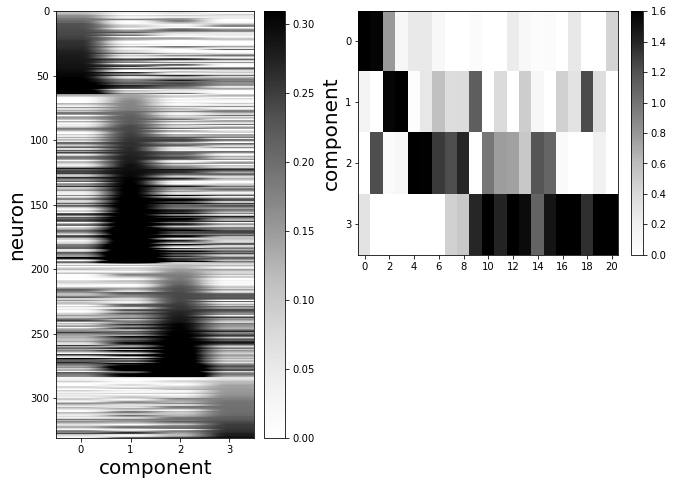

In [10]:
k='0'
nmfp.plot_wh(W_sorted_d[k],H_sorted_d[k])

In [17]:
non_na_original_ind_joint

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [50]:
fac = 3
pyr_within_fac = non_na_original_ind_joint[W_inds_d[k][factor_assignment_d[k] == fac]]

In [51]:
pyr_within_fac

array([186, 207,  59, 132, 217, 328, 216, 219,   8, 263,  82, 235, 146,
       104, 325, 313,  49, 250, 120, 282,  10, 206, 214, 164,  32, 184,
       212, 320, 294, 111, 105,  84,  72, 139, 271, 115, 189,  76,  43,
        71, 268, 154,  78, 228, 197, 141])

In [62]:
W_sorted_d[k][W_inds_d[k]==31]

array([[0.26895696, 0.03016708, 0.        , 0.21197435]])

In [94]:
_,ma,nonind=na.normalize(fr_to_be_nmfed[k].values.T)

In [99]:
nonind

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [71]:
original_inds_sorted_by_one_fac = W_inds_d[k][np.argsort(W_sorted_d[k][:,-1])]
pyr_within_fac_by_magnitude=original_inds_sorted_by_one_fac[-(original_inds_sorted_by_one_fac.shape[0]//4):]
pyr_within_fac_by_magnitude = non_na_original_ind_joint[pyr_within_fac_by_magnitude]

In [72]:
pyr_within_fac_by_magnitude

array([163,  11,  68, 203, 212,  48, 131, 320, 294, 326,  58, 285,  87,
       312,   5, 111, 178,  45,  36,  20, 273,  18, 301, 309, 103,  31,
        41, 116, 105, 196,  85,  55,  34,  84, 276,  72, 125,  96,   6,
        61,  81,  19, 139, 270, 176, 264,  23,  24,  21, 271,  37,  14,
       269, 177,  42,  60, 115,  51, 319, 158,  27, 189,  76,  15,  43,
       318,  71, 268, 191, 154, 122, 302,  70, 310,  62, 161,  78, 228,
       197,   1, 112, 141])

In [43]:
pyr_within_fac

array([186, 207,  59, 132, 217, 328, 216, 219,   8, 263,  82, 235, 146,
       104, 325, 313,  49, 250, 120, 282,  10, 206, 214, 164,  32, 184,
       212, 320, 294, 111, 105,  84,  72, 139, 271, 115, 189,  76,  43,
        71, 268, 154,  78, 228, 197, 141])

<AxesSubplot:xlabel='lin_binned'>

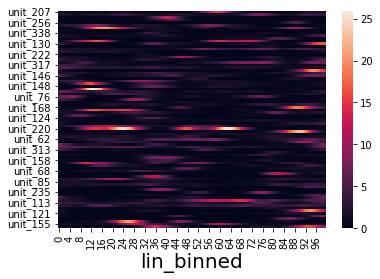

In [73]:
sns.heatmap(fr_map_avg[0].iloc[pyr_within_fac_by_magnitude])

<AxesSubplot:xlabel='lin_binned'>

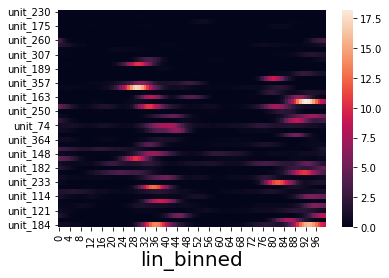

In [44]:
sns.heatmap(fr_map_avg[0].iloc[pyr_within_fac])

In [85]:
non_na_original_ind_joint

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [82]:
pyr_within_fac

array([186, 207,  59, 132, 217, 328, 216, 219,   8, 263,  82, 235, 146,
       104, 325, 313,  49, 250, 120, 282,  10, 206, 214, 164,  32, 184,
       212, 320, 294, 111, 105,  84,  72, 139, 271, 115, 189,  76,  43,
        71, 268, 154,  78, 228, 197, 141])

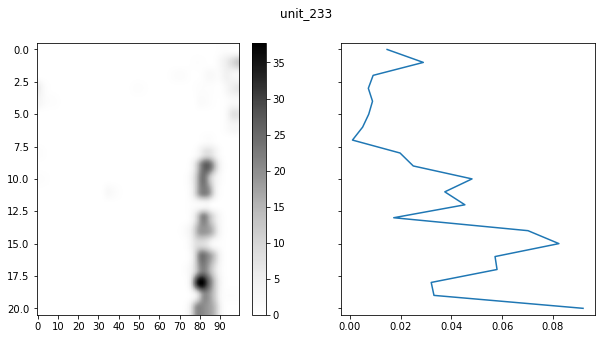

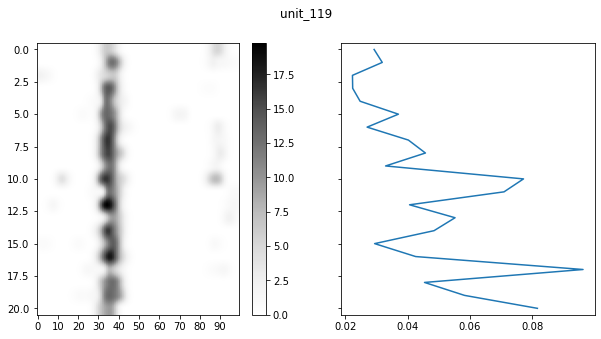

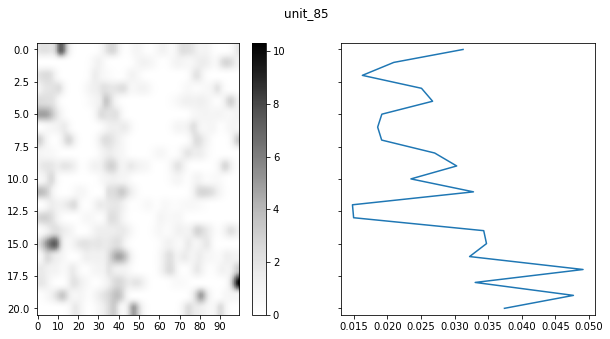

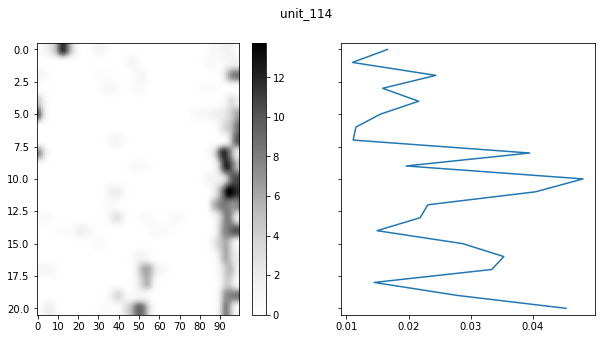

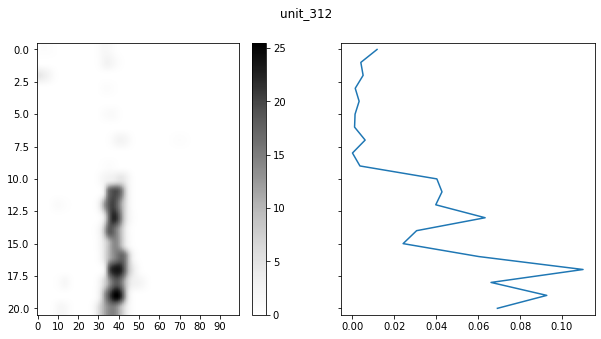

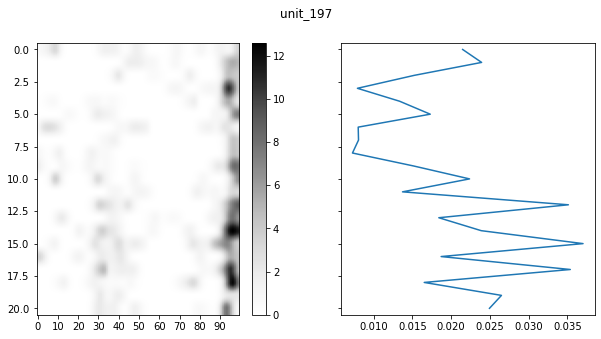

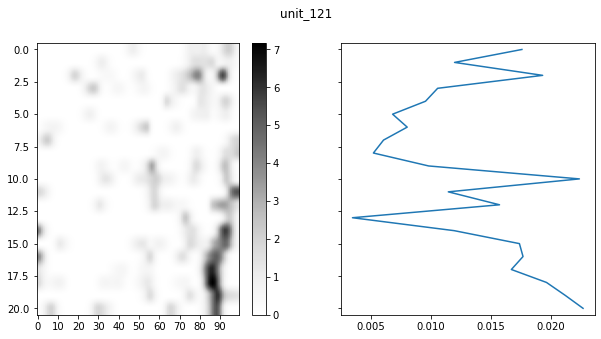

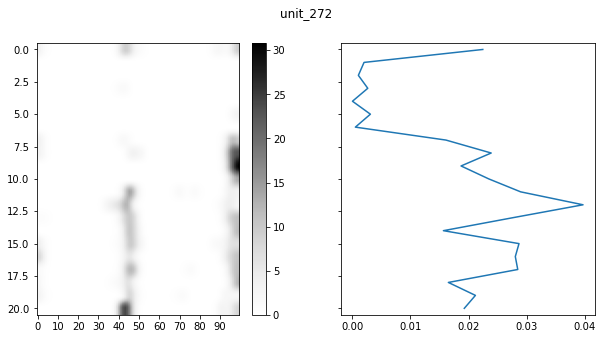

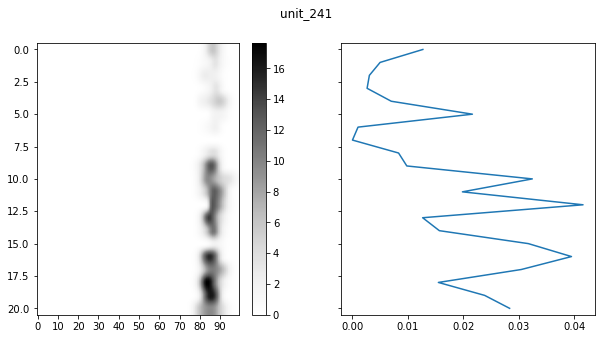

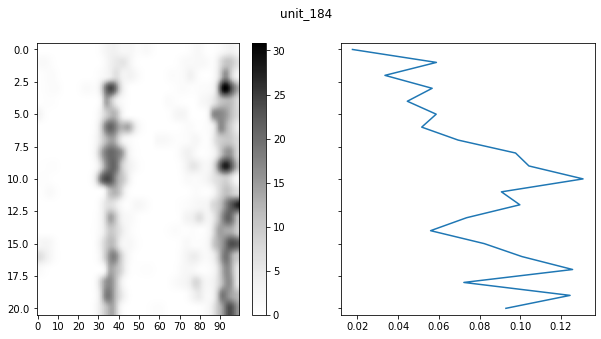

In [166]:
order=pyr_within_fac

for nn in range(-10,0):

    fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
    nmfp.plot_X_sorted(fr_map_trial[int(k)][order][nn].T,spacing=10,fig=fig,ax=ax[0])

    ax[1].plot(fr_to_be_nmfed[k].iloc[:,order].iloc[:,nn],np.arange(fr_to_be_nmfed[k].shape[0]))
    fig.suptitle(cell_cols_pyr[order[nn]])
# ax[1].invert_yaxis()

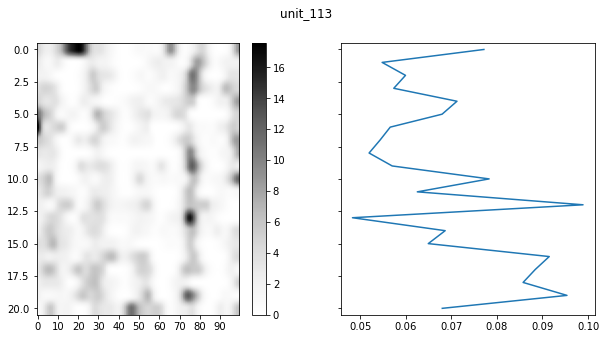

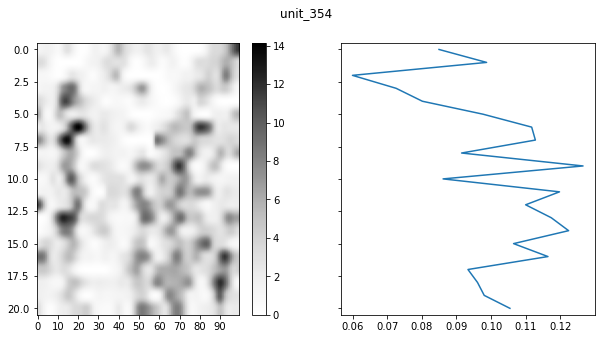

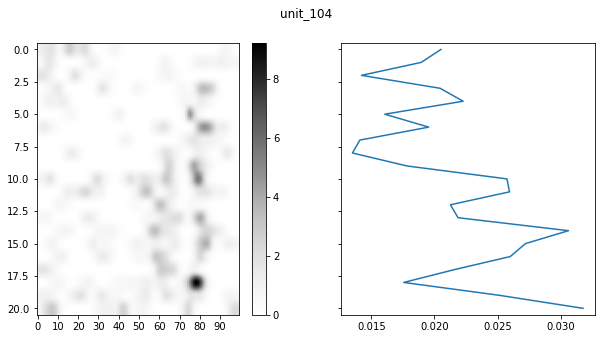

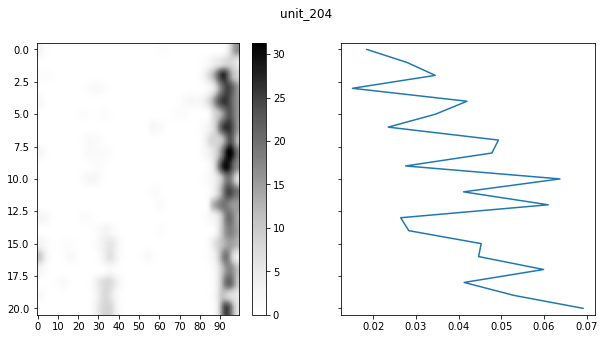

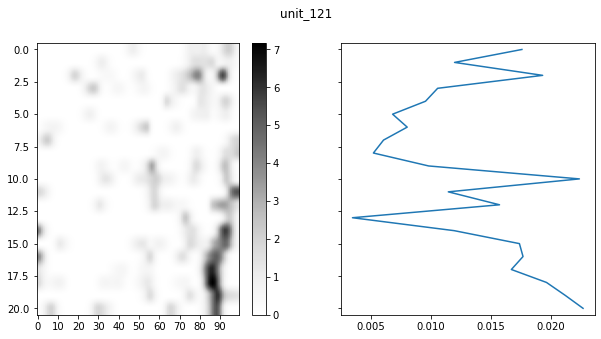

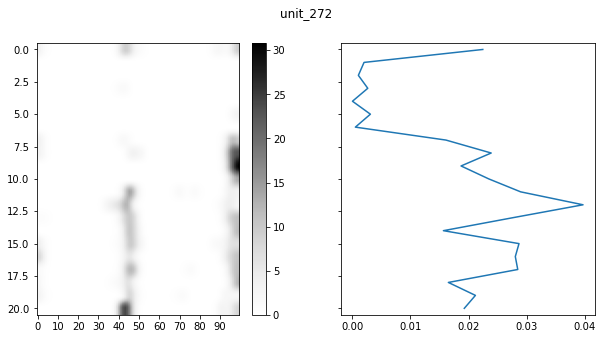

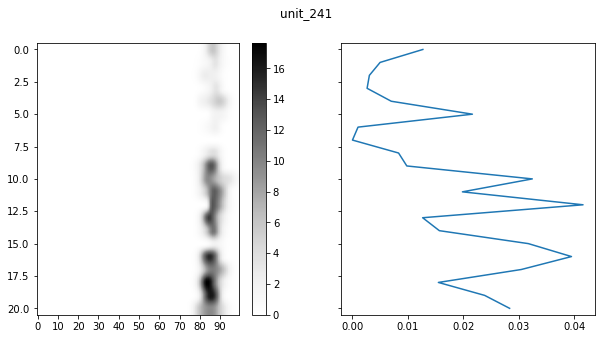

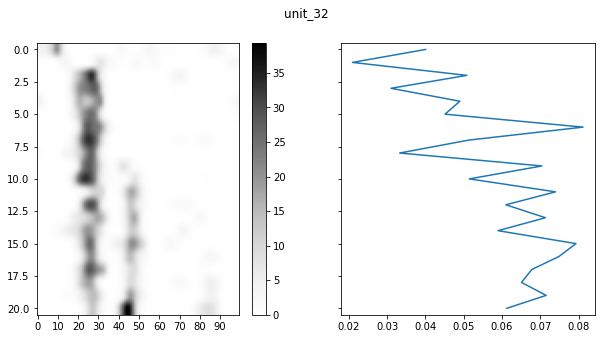

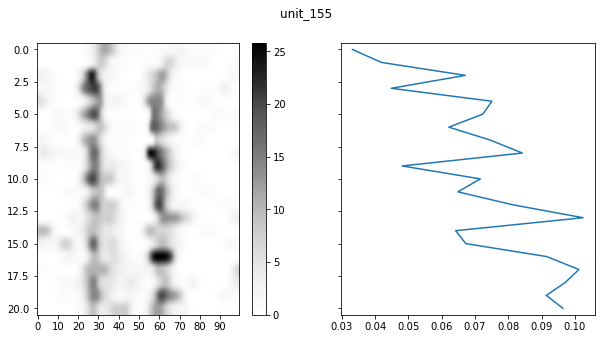

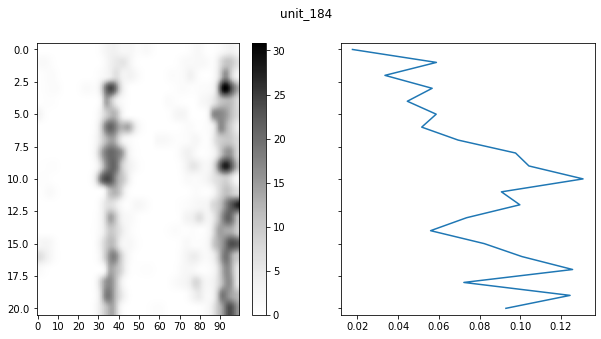

In [165]:
order=pyr_within_fac_by_magnitude

for nn in range(-10,0):

    fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
    nmfp.plot_X_sorted(fr_map_trial[int(k)][order][nn].T,spacing=10,fig=fig,ax=ax[0])

    ax[1].plot(fr_to_be_nmfed[k].iloc[:,order].iloc[:,nn],np.arange(fr_to_be_nmfed[k].shape[0]))
    fig.suptitle(cell_cols_pyr[order[nn]])
# ax[1].invert_yaxis()